### Setup

In [4]:
import lib
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import seaborn as sns

from datetime import datetime, timedelta

l = lib.Offload()

### Lässt sich anhand der Luftqualität etwas über die Anzahl Personen im Raum aussagen?

In [5]:
stundenplan_primar_EG = [
    # week offset, (hour_start, minute_start), (hour_start, minute_start), people
    (0, ( 7, 35), ( 8, 00), 21),
    (0, ( 8,  5), ( 8, 50), 21),
    (0, ( 8, 55), ( 9, 40), 21),
    (0, (10, 00), (10, 45), 21),
    (0, (10, 50), (11, 35), 21),

    (1, ( 7, 35), ( 8, 00), 21),
    (1, ( 8,  5), ( 8, 50), 21),
    (1, ( 8, 55), ( 9, 40), 21),
    (1, (10, 00), (10, 45), 21),
    (1, (13, 30), (14, 15), 11),
    (1, (14, 20), (15,  5), 11),
    (1, (15, 20), (16,  5), 11),

    (2, ( 7, 35), ( 8, 00), 21),
    (2, ( 8,  5), ( 8, 50), 21),
    (2, ( 8, 55), ( 9, 40), 21),
    (2, (10, 00), (10, 45), 21),
    (2, (10, 50), (11, 35), 21),

    (3, ( 7, 35), ( 8, 00), 21),
    (3, ( 8,  5), ( 8, 50), 11),
    (3, ( 8, 55), ( 9, 40), 11),
    (3, (10, 00), (10, 45), 11),
    (3, (10, 50), (11, 35), 11),
    (3, (13, 30), (14, 15), 11),
    (3, (14, 20), (15,  5), 11),
    (3, (15, 20), (16,  5), 11),

    (4, ( 7, 35), ( 8, 00), 21),
    (4, ( 8,  5), ( 8, 50), 21),
    (4, (10, 00), (10, 45), 21),
    (4, (10, 50), (11, 35), 21),
]

In [6]:
co2_buckets_primar_eg_full = l.get_timebuckets_with_diff("Primarklasse_EG", datetime.utcfromtimestamp(0), datetime.now())
co2_buckets_primar_eg_full

,ts,co2_mean,co2_mean_diff,co2_median,co2_median_diff
0,2022-04-22 23:55:00+02:00,1098.40,NaN,1098.0,NaN
1,2022-04-23 00:00:00+02:00,1099.55,1.15,1098.5,0.5
2,2022-04-23 00:05:00+02:00,1096.64,-2.91,1097.0,-1.5
3,2022-04-23 00:10:00+02:00,1098.12,1.48,1098.0,1.0
4,2022-04-23 00:15:00+02:00,1096.36,-1.76,1098.0,0.0
...,...,...,...,...,...
5252,2022-05-14 23:05:00+02:00,1037.03,5.40,1037.0,5.0
5253,2022-05-14 23:10:00+02:00,1031.64,-5.39,1032.0,-5.0
5254,2022-05-14 23:15:00+02:00,1028.08,-3.56,1027.0,-5.0
5255,2022-05-14 23:20:00+02:00,1031.43,3.35,1032.0,5.0


## CO2 level during lessons

In [7]:
co2_primar_eg_lessons = l.get_timebuckets_for_timetable("Primarklasse_EG", stundenplan_primar_EG)
co2_primar_eg_lessons

,ts,co2_mean,co2_mean_diff,co2_median,co2_median_diff,lesson_uuid,people
0,2022-04-25 07:35:00+02:00,876.12,NaN,804.0,NaN,0,21
1,2022-04-25 07:40:00+02:00,794.53,-81.59,830.0,26.0,0,21
2,2022-04-25 07:45:00+02:00,994.19,199.66,1007.0,177.0,0,21
3,2022-04-25 07:50:00+02:00,1060.48,66.29,1050.5,43.5,0,21
4,2022-04-25 07:55:00+02:00,1185.90,125.42,1165.0,114.5,0,21
...,...,...,...,...,...,...,...
4,2022-05-13 11:10:00+02:00,925.25,-12.55,940.0,-7.0,70,21
5,2022-05-13 11:15:00+02:00,1000.81,75.56,1005.0,65.0,70,21
6,2022-05-13 11:20:00+02:00,933.20,-67.61,911.0,-94.0,70,21
7,2022-05-13 11:25:00+02:00,944.86,11.66,952.0,41.0,70,21


Dropping all lessons that have any decrease in CO2 level: We want to keep only the lessons when no kind of ventilation (windows, door) occurred

In [20]:
# collect id's of lessons to drop
lessons_to_drop = []

for index, bucket in co2_primar_eg_lessons.iterrows():
  lesson_id = bucket['lesson_uuid']
  co2_median_diff = bucket['co2_median_diff']

  if co2_median_diff and float(bucket['co2_median_diff']) < 0:
    if lesson_id not in lessons_to_drop:
      lessons_to_drop.append(lesson_id)

# create new df only with lessons that had a steady CO2 increase
co2_primar_eg_lessons_novent = co2_primar_eg_lessons.copy()
for lesson in lessons_to_drop:
  co2_primar_eg_lessons_novent = co2_primar_eg_lessons_novent.loc[~co2_primar_eg_lessons_novent['lesson_uuid'].isin(lessons_to_drop)]

# reset index
co2_primar_eg_lessons_novent = co2_primar_eg_lessons_novent.reset_index()
co2_primar_eg_lessons_novent

,index,ts,co2_mean,co2_mean_diff,co2_median,co2_median_diff,lesson_uuid,people
0,0,2022-04-25 07:35:00+02:00,876.12,NaN,804.0,NaN,0,21
1,1,2022-04-25 07:40:00+02:00,794.53,-81.59,830.0,26.0,0,21
2,2,2022-04-25 07:45:00+02:00,994.19,199.66,1007.0,177.0,0,21
3,3,2022-04-25 07:50:00+02:00,1060.48,66.29,1050.5,43.5,0,21
4,4,2022-04-25 07:55:00+02:00,1185.90,125.42,1165.0,114.5,0,21
...,...,...,...,...,...,...,...,...
77,0,2022-05-06 07:35:00+02:00,934.76,NaN,952.0,NaN,53,21
78,1,2022-05-06 07:40:00+02:00,1009.73,74.97,975.0,23.0,53,21
79,2,2022-05-06 07:45:00+02:00,1107.90,98.17,1097.0,122.0,53,21
80,3,2022-05-06 07:50:00+02:00,1249.20,141.3,1271.0,174.0,53,21


Plotting the distribution of the CO2 changes occurring when no ventilation is going on over whole lessons.

{'whiskers': [<matplotlib.lines.Line2D at 0x7fb6f6dd58e0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fb6f6dd5d60>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fb6f6dd5610>],
 'medians': [<matplotlib.lines.Line2D at 0x7fb6f6de3340>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fb6f6de3610>],
 'means': []}

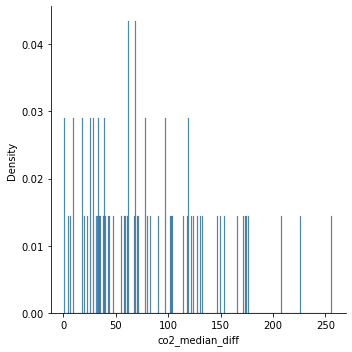

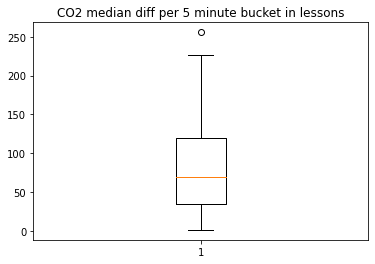

In [28]:
# Distribution
sns.displot(data = co2_primar_eg_lessons_novent, x = 'co2_median_diff', stat="density", common_norm=False)

# Boxplot
fig1, ax1 = plt.subplots()
ax1.set_title('Distribution of CO2 median diffs. to prev. 5 minute buckets in lessons')
ax1.boxplot(co2_primar_eg_lessons_novent['co2_median_diff'].dropna())

Let's look at the increase in CO2 we have in these rooms, per person

{'whiskers': [<matplotlib.lines.Line2D at 0x7fb6f6a5fbb0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fb6f6a56250>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fb6f6a5f9d0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fb6f6a565e0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fb6f6a568b0>],
 'means': []}

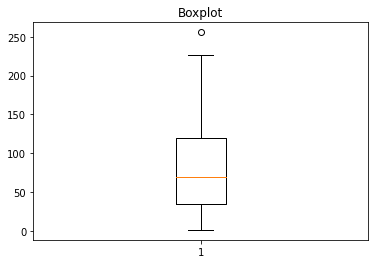

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

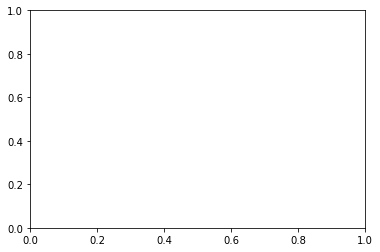

In [11]:
# plot these instances
plt.plot(scalex = co2_primar_eg_lessons_novent['ts'], scaley = co2_primar_eg_lessons_novent['co2_median'])

In [11]:
co2_primar_eg_lessons.loc[(co2_primar_eg_lessons['median_diff'] >= 0)]

,ts,mean,median,mean_diff,median_diff,lesson_uuid,people
1,2022-04-25 07:40:00+02:00,794.53,830.0,-81.59,26.0,0,21
2,2022-04-25 07:45:00+02:00,994.19,1007.0,199.66,177.0,0,21
3,2022-04-25 07:50:00+02:00,1060.48,1050.5,66.29,43.5,0,21
4,2022-04-25 07:55:00+02:00,1185.90,1165.0,125.42,114.5,0,21
2,2022-04-25 08:15:00+02:00,1233.56,1026.0,208.9,1.0,1,21
...,...,...,...,...,...,...,...
1,2022-05-13 10:05:00+02:00,1175.59,1175.0,10.78,10.0,69,21
5,2022-05-13 10:25:00+02:00,901.22,901.0,12.96,13.0,69,21
3,2022-05-13 11:05:00+02:00,937.80,947.0,84.27,103.0,70,21
5,2022-05-13 11:15:00+02:00,1000.81,1005.0,75.56,65.0,70,21


TypeError: unsupported operand type(s) for +: 'float' and 'NoneType'

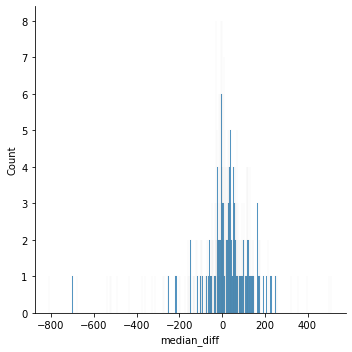

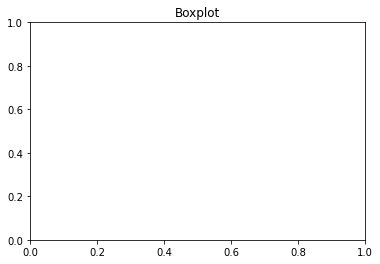

In [9]:
sns.displot(co2_buckets_primar_eg_lessons_only['median_diff'])

fig1, ax1 = plt.subplots()
ax1.set_title('Boxplot')
ax1.boxplot(co2_buckets_primar_eg_lessons_only['median_diff'].filter())

In [12]:
data = l.get_measurement_for_timetable("Primarklasse_EG", stundenplan_primar_EG).sort_values(by=["time"])
data["time_5min"] = data["time"].dt.round("5min")

In [ ]:
min_max = data.groupby(['lesson_uuid', 'time_5min'])[['co2', 'time', 'People']].agg(['min', 'max']).reset_index()
min_max

# min_max['lesson_uuid'] = min_max.index[0]

# mark time frames True, where 5min-grouped min_co2 of previous df entry lower than current min_co2 (no windows opened)
# filter out all lessons where the above condition = False

lesson_uuid                 time_5min     co2          \
                                              min     max   
0             0 2022-04-25 07:35:00+02:00   798.0  1385.0   
1             0 2022-04-25 07:40:00+02:00   579.0   999.0   
2             0 2022-04-25 07:45:00+02:00   829.0  1050.0   
3             0 2022-04-25 07:50:00+02:00  1006.0  1162.0   
4             0 2022-04-25 07:55:00+02:00  1031.0  1233.0   
..          ...                       ...     ...     ...   
642          70 2022-05-13 11:15:00+02:00   881.0  1008.0   
643          70 2022-05-13 11:20:00+02:00   908.0  1008.0   
644          70 2022-05-13 11:25:00+02:00   882.0   964.0   
645          70 2022-05-13 11:30:00+02:00   894.0   962.0   
646          70 2022-05-13 11:35:00+02:00   891.0   894.0   

                                time                                  People  \
                                 min                              max    min   
0   2022-04-25 07:35:03.303713+02:00 2022-04-25 07:37:25.983236+02:00     21   
1   2022-04-25 07:37:31.209242+02:00 2022-04-25 07:42:26.765703+02:00     21   
2   2022-04-25 07:42:31.659147+02:00 2022-04-25 07:47:27.322498+02:00     21   
3   2022-04-25 07:47:32.400284+02:00 2022-04-25 07:52:28.016797+02:00     21   
4   2022-04-25 07:52:33.069090+02:00 2022-04-25 07:57:28.740323+02:00     21   
..                               ...                              ...    ...   
642 2022-05-13 11:12:34.971303+02:00 2022-05-13 11:17:25.569357+02:00     21   
643 2022-05-13 11:17:30.669703+02:00 2022-05-13 11:22:26.399613+02:00     21   
644 2022-05-13 11:22:31.530747+02:00 2022-05-13 11:27:27.137566+02:00     21   
645 2022-05-13 11:27:32.312658+02:00 2022-05-13 11:32:27.991511+02:00     21   
646 2022-05-13 11:32:33.128240+02:00 2022-05-13 11:34:55.692624+02:00     21   

         
    max  
0    21  
1    21  
2    21  
3    21  
4    21  
..   ..  
642  21  
643  21  
644  21  
645  21  
646  21  

[647 rows x 8 columns]

In [ ]:
# non_ventilation_lessons = min_max[(min_max["co2"]["min"].shift(-1) < min_max["co2"]["min"]) & (min_max['lesson_uuid'].shift(-1) == min_max['lesson_uuid'])]
non_ventilation_lessons = min_max
non_ventilation_lessons['diff_co2'] = non_ventilation_lessons["co2"]["min"] - non_ventilation_lessons["co2"]["min"].shift(-1)
# non_ventilation_lessons['same_lesson'] = non_ventilation_lessons["lesson_uuid"] == non_ventilation_lessons["lesson_uuid"].shift(-1)
non_ventilation_lessons['diff_time'] = (non_ventilation_lessons["time"]["min"] - non_ventilation_lessons["time"]["min"].shift(-1)).astype('timedelta64[m]')
non_ventilation_lessons['diff_co2_ratio'] = abs(non_ventilation_lessons["diff_co2"]  / non_ventilation_lessons["diff_time"])
non_ventilation_lessons = non_ventilation_lessons[non_ventilation_lessons["diff_co2"] >= 0]
non_ventilation_lessons

lesson_uuid                 time_5min     co2          \
                                              min     max   
0             0 2022-04-25 07:35:00+02:00   798.0  1385.0   
5             0 2022-04-25 08:00:00+02:00  1134.0  1406.0   
7             1 2022-04-25 08:10:00+02:00  1015.0  1525.0   
8             1 2022-04-25 08:15:00+02:00   957.0  3051.0   
15            1 2022-04-25 08:50:00+02:00  1327.0  1387.0   
..          ...                       ...     ...     ...   
636          69 2022-05-13 10:45:00+02:00   806.0   849.0   
638          70 2022-05-13 10:55:00+02:00   811.0   906.0   
639          70 2022-05-13 11:00:00+02:00   809.0   924.0   
643          70 2022-05-13 11:20:00+02:00   908.0  1008.0   
645          70 2022-05-13 11:30:00+02:00   894.0   962.0   

                                time                                  People  \
                                 min                              max    min   
0   2022-04-25 07:35:03.303713+02:00 2022-04-25 07:37:25.983236+02:00     21   
5   2022-04-25 07:57:33.792829+02:00 2022-04-25 07:59:56.439253+02:00     21   
7   2022-04-25 08:07:30.153425+02:00 2022-04-25 08:12:25.964127+02:00     21   
8   2022-04-25 08:12:30.980000+02:00 2022-04-25 08:17:26.671660+02:00     21   
15  2022-04-25 08:47:31.230709+02:00 2022-04-25 08:49:59.031572+02:00     21   
..                               ...                              ...    ...   
636 2022-05-13 10:42:30.600932+02:00 2022-05-13 10:44:58.461960+02:00     21   
638 2022-05-13 10:52:32.346115+02:00 2022-05-13 10:57:27.848591+02:00     21   
639 2022-05-13 10:57:32.919781+02:00 2022-05-13 11:02:28.499665+02:00     21   
643 2022-05-13 11:17:30.669703+02:00 2022-05-13 11:22:26.399613+02:00     21   
645 2022-05-13 11:27:32.312658+02:00 2022-05-13 11:32:27.991511+02:00     21   

          diff diff_co2 diff_time diff_co2_ratio same_lesson  
    max                                                       
0    21  219.0    219.0      -3.0      73.000000        True  
5    21  186.0    186.0      -8.0      23.250000       False  
7    21   58.0     58.0      -6.0       9.666667        True  
8    21   54.0     54.0      -6.0       9.000000        True  
15   21  699.0    699.0      -8.0      87.375000       False  
..   ..    ...      ...       ...            ...         ...  
636  21   23.0     23.0      -8.0       2.875000       False  
638  21    2.0      2.0      -6.0       0.333333        True  
639  21    1.0      1.0      -6.0       0.166667        True  
643  21   26.0     26.0      -6.0       4.333333        True  
645  21    3.0      3.0      -6.0       0.500000        True  

[257 rows x 13 columns]

In [ ]:
# prev = None
# for entry in non_ventilation_lessons:
#   if not entry["lesson_uuid"] == prev and not entry["lesson_uuid"] == prev:
#     print(entry.index)
#   prev = entry["lesson_uuid"]

non_ventilation_lessons.drop(non_ventilation_lessons[non_ventilation_lessons['lesson_uuid'] != non_ventilation_lessons['lesson_uuid'].shift(-1)].index, inplace = True)
non_ventilation_lessons

/var/folders/q8/fglxv79s1t91hf9dj58bk2gc0000gn/T/ipykernel_69360/345946781.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_ventilation_lessons.drop(non_ventilation_lessons[non_ventilation_lessons['lesson_uuid'] != non_ventilation_lessons['lesson_uuid'].shift(-1)].index, inplace = True)


lesson_uuid                 time_5min     co2          \
                                              min     max   
7             1 2022-04-25 08:10:00+02:00  1015.0  1525.0   
19            2 2022-04-25 09:10:00+02:00  1253.0  1388.0   
22            2 2022-04-25 09:25:00+02:00  1264.0  1295.0   
23            2 2022-04-25 09:30:00+02:00  1242.0  1368.0   
36            4 2022-04-25 10:50:00+02:00  1337.0  1358.0   
..          ...                       ...     ...     ...   
630          69 2022-05-13 10:15:00+02:00   907.0  1017.0   
632          69 2022-05-13 10:25:00+02:00   887.0   903.0   
633          69 2022-05-13 10:30:00+02:00   880.0   907.0   
638          70 2022-05-13 10:55:00+02:00   811.0   906.0   
639          70 2022-05-13 11:00:00+02:00   809.0   924.0   

                                time                                  People  \
                                 min                              max    min   
7   2022-04-25 08:07:30.153425+02:00 2022-04-25 08:12:25.964127+02:00     21   
19  2022-04-25 09:07:31.776980+02:00 2022-04-25 09:12:27.409529+02:00     21   
22  2022-04-25 09:22:33.737079+02:00 2022-04-25 09:27:29.458960+02:00     21   
23  2022-04-25 09:27:34.607225+02:00 2022-04-25 09:32:25.038016+02:00     21   
36  2022-04-25 10:50:03.700471+02:00 2022-04-25 10:52:26.419900+02:00     21   
..                               ...                              ...    ...   
630 2022-05-13 10:12:31.196032+02:00 2022-05-13 10:17:26.837571+02:00     21   
632 2022-05-13 10:22:32.621769+02:00 2022-05-13 10:27:28.217229+02:00     21   
633 2022-05-13 10:27:33.367619+02:00 2022-05-13 10:32:28.989098+02:00     21   
638 2022-05-13 10:52:32.346115+02:00 2022-05-13 10:57:27.848591+02:00     21   
639 2022-05-13 10:57:32.919781+02:00 2022-05-13 11:02:28.499665+02:00     21   

          diff diff_co2 diff_time diff_co2_ratio same_lesson  
    max                                                       
7    21   58.0     58.0      -6.0       9.666667        True  
19   21   15.0     15.0      -6.0       2.500000        True  
22   21   22.0     22.0      -6.0       3.666667        True  
23   21   96.0     96.0      -5.0      19.200000        True  
36   21  422.0    422.0      -3.0     140.666667        True  
..   ..    ...      ...       ...            ...         ...  
630  21   24.0     24.0      -6.0       4.000000        True  
632  21    7.0      7.0      -6.0       1.166667        True  
633  21   48.0     48.0      -6.0       8.000000        True  
638  21    2.0      2.0      -6.0       0.333333        True  
639  21    1.0      1.0      -6.0       0.166667        True  

[132 rows x 13 columns]

{'whiskers': [<matplotlib.lines.Line2D at 0x7f8fbb9952e0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f8fbb995880>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f8fbb989fd0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f8fbb995dc0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f8fbb9a00d0>],
 'means': []}

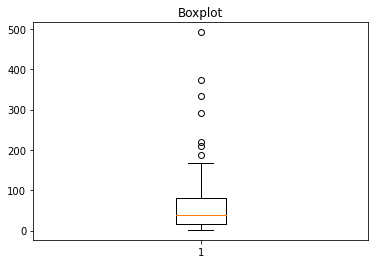

In [ ]:
non_ventilation_lessons_mean_co2 = non_ventilation_lessons.groupby("lesson_uuid")['diff_co2'].mean()
non_ventilation_lessons_mean_co2

fig1, ax1 = plt.subplots()
ax1.set_title('Boxplot')
ax1.boxplot(non_ventilation_lessons_mean_co2)

In [ ]:
no_ventilation = \
    {
        "Primarklasse_EG": [
            {"from": "2022-05-04 07:41:00", "to": "2022-05-04 8:02:00", "people": 21},
            {"from": "2022-05-04 08:06:00", "to": "2022-05-04 8:37:00", "people": 21},
            {"from": "2022-05-05 08:09:00", "to": "2022-05-05 9:44:00", "people": 11},
            {"from": "2022-05-05 14:22:00", "to": "2022-05-05 15:10:00", "people": 11},
        ],
        "Primarklasse_OG1": [
            
        ],
        "oberstufe": [

        ]
    }

non_vent_example = l.get_measurement(name = "Primarklasse_EG", startDate = "2022-05-04 07:41:00", endDate= "2022-05-04 8:02:00")
non_vent_example['people'] = 21

/Users/yvokeller/opt/anaconda3/envs/datascience/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [ ]:
non_vent_example_n = non_vent_example
non_vent_example_n["time_1min"] = non_vent_example_n["time"].dt.round("1min")
non_vent_example_n = non_vent_example_n.groupby(['time_1min'])[['co2', 'time']].agg(['min', 'max', 'median']).reset_index()
non_vent_example_n['diff_co2'] = non_vent_example_n["co2"]["median"] - non_vent_example_n["co2"]["median"].shift() # diff between current & prev row
non_vent_example_n

time_1min     co2                  \
                                 min     max  median   
0  2022-05-04 07:41:00+02:00   894.0   898.0   896.5   
1  2022-05-04 07:42:00+02:00   893.0   981.0   953.0   
2  2022-05-04 07:43:00+02:00   989.0  1090.0  1069.0   
3  2022-05-04 07:44:00+02:00  1094.0  1116.0  1114.0   
4  2022-05-04 07:45:00+02:00  1116.0  1119.0  1118.5   
5  2022-05-04 07:46:00+02:00  1117.0  1120.0  1119.0   
6  2022-05-04 07:47:00+02:00  1120.0  1122.0  1122.0   
7  2022-05-04 07:48:00+02:00  1123.0  1135.0  1130.0   
8  2022-05-04 07:49:00+02:00  1135.0  1148.0  1140.0   
9  2022-05-04 07:50:00+02:00  1148.0  1166.0  1158.0   
10 2022-05-04 07:51:00+02:00  1167.0  1211.0  1188.0   
11 2022-05-04 07:52:00+02:00  1213.0  1270.0  1242.0   
12 2022-05-04 07:53:00+02:00  1274.0  1307.0  1297.5   
13 2022-05-04 07:54:00+02:00  1306.0  1315.0  1311.5   
14 2022-05-04 07:55:00+02:00  1315.0  1355.0  1318.5   
15 2022-05-04 07:56:00+02:00  1382.0  1411.0  1399.0   
16 2022-05-04 07:57:00+02:00  1413.0  1418.0  1416.0   
17 2022-05-04 07:58:00+02:00  1417.0  1444.0  1427.0   
18 2022-05-04 07:59:00+02:00  1448.0  1474.0  1463.5   
19 2022-05-04 08:00:00+02:00  1476.0  1498.0  1484.0   
20 2022-05-04 08:01:00+02:00  1500.0  1514.0  1507.5   
21 2022-05-04 08:02:00+02:00  1515.0  1519.0  1516.5   

                               time                                   \
                                min                              max   
0  2022-05-04 07:41:03.171819+02:00 2022-05-04 07:41:28.619252+02:00   
1  2022-05-04 07:41:33.702979+02:00 2022-05-04 07:42:29.786553+02:00   
2  2022-05-04 07:42:34.906608+02:00 2022-05-04 07:43:25.998963+02:00   
3  2022-05-04 07:43:30.927047+02:00 2022-05-04 07:44:27.200187+02:00   
4  2022-05-04 07:44:32.221647+02:00 2022-05-04 07:45:28.130376+02:00   
5  2022-05-04 07:45:33.257495+02:00 2022-05-04 07:46:29.283786+02:00   
6  2022-05-04 07:46:34.336103+02:00 2022-05-04 07:47:25.300874+02:00   
7  2022-05-04 07:47:30.501197+02:00 2022-05-04 07:48:26.448649+02:00   
8  2022-05-04 07:48:31.725894+02:00 2022-05-04 07:49:27.691103+02:00   
9  2022-05-04 07:49:32.736247+02:00 2022-05-04 07:50:28.784261+02:00   
10 2022-05-04 07:50:33.890445+02:00 2022-05-04 07:51:29.939833+02:00   
11 2022-05-04 07:51:35.091809+02:00 2022-05-04 07:52:26.037114+02:00   
12 2022-05-04 07:52:31.128093+02:00 2022-05-04 07:53:27.169713+02:00   
13 2022-05-04 07:53:32.263541+02:00 2022-05-04 07:54:28.448357+02:00   
14 2022-05-04 07:54:33.534636+02:00 2022-05-04 07:55:29.471277+02:00   
15 2022-05-04 07:55:34.596520+02:00 2022-05-04 07:56:25.517457+02:00   
16 2022-05-04 07:56:30.689862+02:00 2022-05-04 07:57:26.655810+02:00   
17 2022-05-04 07:57:31.833500+02:00 2022-05-04 07:58:27.844086+02:00   
18 2022-05-04 07:58:32.969921+02:00 2022-05-04 07:59:28.999672+02:00   
19 2022-05-04 07:59:34.124812+02:00 2022-05-04 08:00:25.099558+02:00   
20 2022-05-04 08:00:30.310096+02:00 2022-05-04 08:01:26.228077+02:00   
21 2022-05-04 08:01:31.333534+02:00 2022-05-04 08:01:56.769151+02:00   

                                       diff_co2  
                                median           
0  2022-05-04 07:41:15.998054400+02:00      NaN  
1  2022-05-04 07:42:01.777506048+02:00     56.5  
2  2022-05-04 07:43:00.405116928+02:00    116.0  
3  2022-05-04 07:43:58.982791680+02:00     45.0  
4  2022-05-04 07:45:00.113440256+02:00      4.5  
5  2022-05-04 07:46:01.257726464+02:00      0.5  
6  2022-05-04 07:46:59.858988032+02:00      3.0  
7  2022-05-04 07:47:58.441720064+02:00      8.0  
8  2022-05-04 07:48:59.585508864+02:00     10.0  
9  2022-05-04 07:50:00.704670464+02:00     18.0  
10 2022-05-04 07:51:01.923135488+02:00     30.0  
11 2022-05-04 07:52:00.590539008+02:00     54.0  
12 2022-05-04 07:52:59.149567488+02:00     55.5  
13 2022-05-04 07:54:00.319676416+02:00     14.0  
14 2022-05-04 07:55:01.546534912+02:00      7.0  
15 2022-05-04 07:56:00.043979008+02:00     80.5  
16 2022-05-04 07:56:58.666813952+02:00     17

ArgumentError: Could not parse rfc1738 URL from string '
            SET timezone = 'CET';
            SELECT * FROM timebuckets_primarklasse_eg;
        '

#### With People counter

In [ ]:
## Week 1 Korrelation People to Co2

df_people = l.get_people_count_overtime(l.get_entrance('Primarklasse_EG', startDate = "2022-05-02 05:00:00", endDate = "2022-05-02 17:30:00"))
data = l.get_measurement(name = "Primarklasse_EG", startDate = "2022-05-02 05:00:00", endDate = "2022-05-02 17:30:00")

plt.figure(figsize = (15,3))
plt.plot(data["time"], data["co2"])
plt.xlabel("Time")
plt.ylabel("CO2 in PPM")
plt.title("CO2 Verhältnis am 02.05.2022 im Classroom Primar")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.grid()
plt.show()


plt.figure(figsize = (15,3))
plt.plot(df_people["time"], df_people["people_count"])
plt.xlabel("Time")
plt.ylabel("Personenanzahl")
plt.title("Personen im Klassenzimmer am 02.05.2022 im Classroom oberstufe")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.grid()
plt.show()

print(data.describe())
print(f'Korrelation:{data.corrwith(df_people.people_count).co2}')


df_people = l.get_people_count_overtime(l.get_entrance('Primarklasse_EG', startDate = "2022-05-03 05:00:00", endDate = "2022-05-03 17:30:00"))
data = l.get_measurement(name = "Primarklasse_EG", startDate = "2022-05-03 05:00:00", endDate = "2022-05-03 17:30:00")


plt.figure(figsize = (15,3))
plt.plot(data["time"], data["co2"])
plt.xlabel("Time")
plt.ylabel("CO2 in PPM")
plt.title("CO2 Verhältnis am 03.05.2022 im Classroom Primar")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.grid()
plt.show()


plt.figure(figsize = (15,3))
plt.plot(df_people["time"], df_people["people_count"])
plt.xlabel("Time")
plt.ylabel("Personenanzahl")
plt.title("Personen im Klassenzimmer am 03.05.2022 im Classroom oberstufe")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.grid()
plt.show()

print(data.describe())
print(f'Korrelation:{data.corrwith(df_people.people_count).co2}')

df_people = l.get_people_count_overtime(l.get_entrance('Primarklasse_EG', startDate = "2022-05-04 05:00:00", endDate = "2022-05-04 17:30:00"))
data = l.get_measurement(name = "Primarklasse_EG", startDate = "2022-05-04 05:00:00", endDate = "2022-05-04 17:30:00")


plt.figure(figsize = (15,3))
plt.plot(data["time"], data["co2"])
plt.xlabel("Time")
plt.ylabel("CO2 in PPM")
plt.title("CO2 Verhältnis am 04.05.2022 im Classroom Primar")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.grid()
plt.show()


plt.figure(figsize = (15,3))
plt.plot(df_people["time"], df_people["people_count"])
plt.xlabel("Time")
plt.ylabel("Personenanzahl")
plt.title("Personen im Klassenzimmer am 04.05.2022 im Classroom oberstufe")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.grid()
plt.show()

print(data.describe())
print(f'Korrelation:{data.corrwith(df_people.people_count).co2}')

df_people = l.get_people_count_overtime(l.get_entrance('Primarklasse_EG', startDate = "2022-05-05 05:00:00", endDate = "2022-05-05 17:30:00"))
data = l.get_measurement(name = "Primarklasse_EG", startDate = "2022-05-05 05:00:00", endDate = "2022-05-05 17:30:00")


plt.figure(figsize = (15,3))
plt.plot(data["time"], data["co2"])
plt.xlabel("Time")
plt.ylabel("CO2 in PPM")
plt.title("CO2 Verhältnis am 05.05.2022 im Classroom Primar")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.grid()
plt.show()


plt.figure(figsize = (15,3))
plt.plot(df_people["time"], df_people["people_count"])
plt.xlabel("Time")
plt.ylabel("Personenanzahl")
plt.title("Personen im Klassenzimmer am 05.05.2022 im Classroom oberstufe")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.grid()
plt.show()

print(data.describe())
print(f'Korrelation:{data.corrwith(df_people.people_count).co2}')

NameError: name 'l' is not defined

#### Mit Studenplan Personen zählen und Klassenliste

/Users/yvokeller/opt/anaconda3/envs/datascience/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


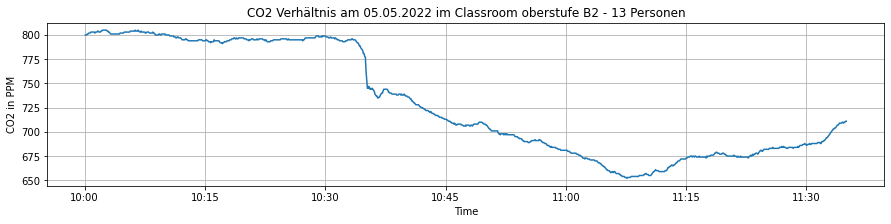

/Users/yvokeller/opt/anaconda3/envs/datascience/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


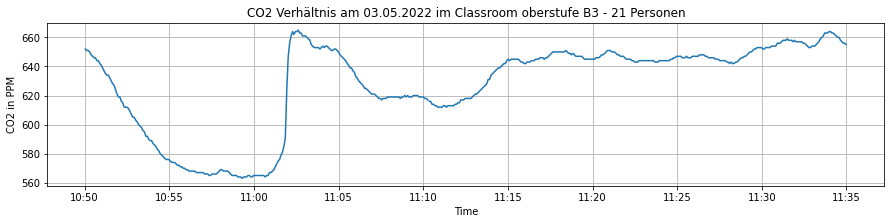

/Users/yvokeller/opt/anaconda3/envs/datascience/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


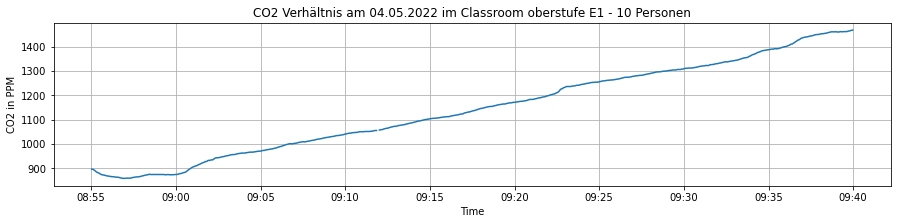

/Users/yvokeller/opt/anaconda3/envs/datascience/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


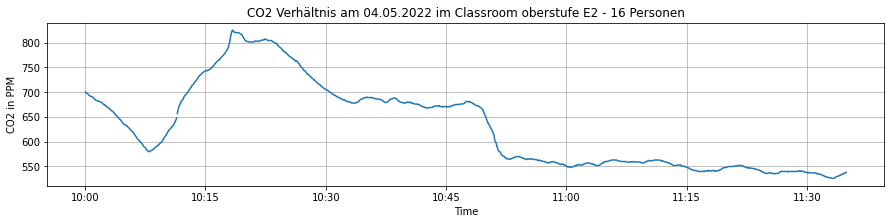

/Users/yvokeller/opt/anaconda3/envs/datascience/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


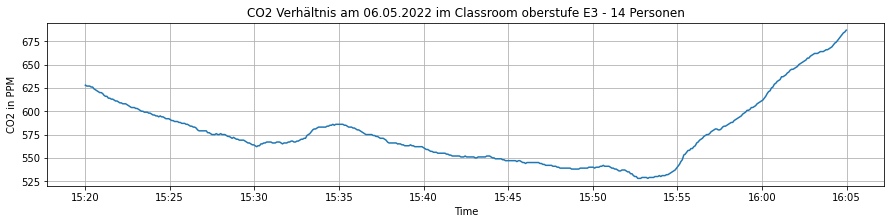

In [ ]:
# Auswertung Oberstufe

# Missing Data at the moment : B1 = get_measurement(name = "oberstufe", startDate = "2022-05-02 10:00:00", endDate = "2022-05-02 11:35:00")

B2 = l.get_measurement(name = "oberstufe", startDate = "2022-05-05 10:00:00", endDate = "2022-05-05 11:35:00")


plt.figure(figsize = (15,3))
plt.plot(B2["time"], B2["co2"])
plt.xlabel("Time")
plt.ylabel("CO2 in PPM")
plt.title("CO2 Verhältnis am 05.05.2022 im Classroom oberstufe B2 - 13 Personen")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.grid()
plt.show()

B3 = l.get_measurement(name = "oberstufe", startDate = "2022-05-03 10:50:00", endDate = "2022-05-03 11:35:00")

plt.figure(figsize = (15,3))
plt.plot(B3["time"], B3["co2"])
plt.xlabel("Time")
plt.ylabel("CO2 in PPM")
plt.title("CO2 Verhältnis am 03.05.2022 im Classroom oberstufe B3 - 21 Personen")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.grid()
plt.show()

E1 = l.get_measurement(name = "oberstufe", startDate = "2022-05-04 8:55:00", endDate = "2022-05-04 9:40:00")

plt.figure(figsize = (15,3))
plt.plot(E1["time"], E1["co2"])
plt.xlabel("Time")
plt.ylabel("CO2 in PPM")
plt.title("CO2 Verhältnis am 04.05.2022 im Classroom oberstufe E1 - 10 Personen")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.grid()
plt.show()

E2 = l.get_measurement(name = "oberstufe", startDate = "2022-05-04 10:00:00", endDate = "2022-05-04 11:35:00")

plt.figure(figsize = (15,3))
plt.plot(E2["time"], E2["co2"])
plt.xlabel("Time")
plt.ylabel("CO2 in PPM")
plt.title("CO2 Verhältnis am 04.05.2022 im Classroom oberstufe E2 - 16 Personen")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.grid()
plt.show()

E3 = l.get_measurement(name = "oberstufe", startDate = "2022-05-06 15:20:00", endDate = "2022-05-06 16:05:00")

plt.figure(figsize = (15,3))
plt.plot(E3["time"], E3["co2"])
plt.xlabel("Time")
plt.ylabel("CO2 in PPM")
plt.title("CO2 Verhältnis am 06.05.2022 im Classroom oberstufe E3 - 14 Personen")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.grid()
plt.show()
